# MathFeed SVM

### Notes
- verify that features we use in model will be attainable from scraping

- consider various ways to define quality
    - number of times reacted to
    - whether or not domain is "well-known or established"
    - other ways??
    

- figure out how to merge text data with other features


In [1]:
#important libraries
import xml.etree.ElementTree as ET
from lxml import etree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import time

#try different methods for text vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

#algorithms
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

#metrics
from sklearn.metrics import confusion_matrix


## Read in Data

In [2]:
#function for reading in the data as xml
def xml2df(xml_data):
    '''
    This function takes the MathFeed Data in an xml format
    and puts it into a pandas data frame
    '''
    tree = ET.parse(xml_data)
    root = tree.getroot()
    all_records = []
    headers = []
    for i, child in enumerate(root):
        record = []
        for subchild in child:
            record.append(subchild.text)
            if subchild.tag not in headers:
                headers.append(subchild.tag)
        all_records.append(record)
    return pd.DataFrame(all_records, columns=headers)

In [3]:
#read in and look at data
file = 'MathFeedsDataAll.xml'
data = xml2df(file)
data.head()
data

,URL,Title,Text,Domain,blurb,date,image,isbn,kicker,price,timesDeleted,timesEmailed,timesOpened,timesSaved,timesShared,timestamp,wordtitle
0,http://blogs.ams.org/mathgradblog/2017/01/05/d...,Up to Date Blog Content for JMM 2017,Looking for blog content about the 2017 Joint ...,blogs.ams.org,Looking for blog content about the 2017 Joint ...,01/05/17,None,nan,GRADUATE STUDENT BLOG,nan,1.0,nan,4.0,nan,nan,5774489532.046694,uptodateblogcontentforjmm2017
1,http://mrhonner.com/archives/17215,Math Photo: A Dodecagon of Octagons « Mr Honner,I’d never looked closely at the Parachute Jump...,mrhonner.com,I'd never looked closely at the Parachute Jump...,09/18/16,http://MrHonner.com/wp-content/uploads/2016/09...,nan,NOTABLE,nan,nan,nan,nan,nan,nan,5783496448.673001,mathphotoadodecagonofoctagons
2,https://mathbabe.org/2017/03/21/guest-post-the...,Guest post: the age of algorithms | mathbabe,Artie has kindly allowed me to post his though...,mathbabe.org,Artie has kindly allowed me to post his though...,03/21/17,None,nan,BLOG,nan,2.0,2.0,11.0,1.0,nan,5767987618.7198305,guestposttheageofalgorithms
3,http://www.scientificamerican.com/podcast/epis...,Sean M. Carroll Looks at The Big Picture - Sci...,Steve Mirsky: Welcome to Scientific American's...,scientificamerican.com,Caltech theoretical physicist Sean M. Carroll ...,05/12/16,https://www.scientificamerican.com/sciam/cache...,nan,None,nan,nan,nan,nan,nan,nan,5795107200.0,seanmcarrolllooksatthebigpicture
4,http://the-japan-news.com/news/article/0003176002,The Japan News,Not found\n\nThe requested server cannot be ac...,the-japan-news.com,The education ministry will open research cent...,09/13/16,http://the-japan-news.com/modules/img/logo_ogp...,nan,BIG DATA,nan,nan,nan,nan,nan,nan,5784392943.842338,educationministrytopromoteuseofbigdata
5,http://digg.com/video/acquired-savant,A Normal Dude Suffered Head Trauma And Woke Up...,SCHOOL OF HARD KNOCKS A Normal Dude Suffered H...,digg.com,Jason Padgett is a completely different person...,12/24/16,http://static.digg.com/images/e907a4783efe4e29...,nan,VIDEO,nan,1.0,nan,22.0,2.0,nan,5775558705.78157,anormaldudesufferedheadtraumaandwokeupamathema...
6,https://amp.pastemagazine.com/articles/2016/12...,A Math Savant Defects from North Korea in J.M....,"North Korea has long fascinated storytellers, ...",amp.pastemagazine.com,The protagonist tells his story from FBI custo...,12/31/16,https://cdn.pastemagazine.com/www/articles/1bo...,The Boy Who Escaped Paradise by JM Lee,BOOK REVIEW,nan,2.0,nan,15.0,nan,nan,5774932303.488599,amathsavantdefectsfromnorthkoreainjmleestheboy...
7,https://amp.pastemagazine.com/articles/2016/12...,A Math Savant Defects from North Korea in J.M....,"North Korea has long fascinated storytellers, ...",amp.pastemagazine.com,The protagonist tells his story from FBI custo...,12/31/16,https://cdn.pastemagazine.com/www/articles/1bo...,The Boy Who Escaped Paradise by JM Lee,BOOK REVIEW,nan,2.0,nan,15.0,nan,nan,5774932303.488599,amathsavantdefectsfromnorthkoreainjmleestheboy...
8,http://blogs.ams.org/visualinsight/2016/03/01/...,Clebsch Surface | Visual Insight,"This is an image of the Clebsch surface, creat...",blogs.ams.org,"This is an image of the Clebsch surface, creat...",03/01/16,http://blogs.ams.org/visualinsight/files/2016/...,nan,BLOG: VISUAL INSIGHT,nan,nan,nan,nan,nan,nan,5801328000.0,clebschsurface
9,https://www.nytimes.com/2017/02/03/education/e...,Trying to Solve a Bigger Math Problem - The Ne...,Photo\n\nAlgebra is clearly a stumbling block ...,nytimes.com,Algebra is a stumbling block for many freshmen...,02/03/17,https://static01.nyt.com/images/2017/02/05/edu...,nan,None,nan,3.0,1.0,45.0,0.0,nan,5771973041.9822445,tryingtosolveabiggermathproblem


In [4]:
#dimensions and summary stats of data
print(data.shape)
data.describe()

(4674, 17)


,URL,Title,Text,Domain,blurb,date,image,isbn,kicker,price,timesDeleted,timesEmailed,timesOpened,timesSaved,timesShared,timestamp,wordtitle
count,4674,4674,4617,4674,4674,4674,4048,4672,3683,4674,4674,4674,4674,4674,4674,4674,4674
unique,4444,4132,3730,409,4425,594,3009,256,674,35,7,9,62,12,9,4245,4381
top,http://store.maa.org/site/index.php?app=ecom&n...,Mathematical Monthly - Vol123-N10,Journals of the Mathematical Association of Am...,maa.org,This is a challenging problem solving book in ...,03/26/17,nan,nan,BLOG,nan,nan,nan,nan,nan,nan,5788108800.0,frommaa_photo
freq,9,14,270,346,9,44,239,4338,484,4588,2935,4212,2671,3648,4272,10,13


In [5]:
#names of all columns
data.columns

Index(['URL', 'Title', 'Text', 'Domain', 'blurb', 'date', 'image', 'isbn',
       'kicker', 'price', 'timesDeleted', 'timesEmailed', 'timesOpened',
       'timesSaved', 'timesShared', 'timestamp', 'wordtitle'],
      dtype='object')

## Data Cleaning and Feature Engineering

The comments in the following code should explain the gist of what I did. I didn't bump things over to an 'other' category unless they had less than 10 observations. This was just an arbitrary choice on my part, and can be modified. (Some people say that ~50 observations is a good minimum.)

In [6]:
# Initial Cleaning

#drop unwanted columns and delete duplicate rows
keeps = ['Title','Text','Domain','image','isbn','kicker','timesDeleted','timesEmailed',
         'timesOpened','timesSaved','timesShared']

#make all changes to 'temp' dataframe before saving it as the final, cleaned dataframe
temp = data[keeps].drop_duplicates()
print('Duplicate Observations:',data.shape[0]-temp.shape[0])

#convert user action columns (times opened, times saved, etc) to numeric 
def col2numeric(df,act_cols):
    '''
    converts the non_numeric columns of user actions into numeric data
    turns NaN values to zero
    '''
    for i in act_cols:
        df[i] = np.where(df[i] == 'nan',0,df[i])
        df[i] = pd.to_numeric(df[i])
    return df
# act_cols == list of user action columns
act_cols = ['timesShared', 'timesOpened', 'timesSaved', 'timesEmailed', 'timesDeleted']
temp= col2numeric(temp,act_cols)

#change image to categorical: 1 = has image, 0 = no image
temp.image = np.where((temp.image == 'None') ,0,temp.image)
temp.image = np.where((temp.image == 'nan') ,0,temp.image)
temp.image = np.where((temp.image != 0),1,temp.image)

#change isbn to categorical: 1 = has isbn, 0 = no isbn
#NOTE: some isbn values are labels (title and author) rather than numbers
temp.isbn = np.where(temp.isbn != 'nan',1,0)

###group together similar kickers
temp.kicker = np.array(temp.kicker,dtype='str')#included this line since *None* values didn't work in np.where
temp.kicker = np.where(temp.kicker=='nan','MISSING',temp.kicker)
temp.kicker = np.where(temp.kicker == 'None','MISSING',temp.kicker)
#group together all BLOGS, TWEETS, VIDEOS, etc 
temp.kicker = np.where(temp.kicker.str.contains('BLOG'),'BLOG',temp.kicker)
temp.kicker = np.where(temp.kicker.str.contains('TWEET'),'TWEET',temp.kicker)
temp.kicker = np.where(temp.kicker.str.contains('MAA'),'MAA',temp.kicker)
temp.kicker = np.where(temp.kicker.str.contains('VIDEO'),'VIDEO',temp.kicker)
temp.kicker = np.where(temp.kicker.str.contains('REVIEW'),'REVIEW',temp.kicker)
temp.kicker = np.where(temp.kicker.str.contains('PUZZLE'),'PUZZLE',temp.kicker)
temp.kicker = np.where(temp.kicker.str.contains('HAT TIP @'),'HAT TIP @',temp.kicker)
temp.kicker = np.where(temp.kicker.str.contains('REDDIT'),'REDDIT',temp.kicker)
temp.kicker = np.where(temp.kicker.str.contains('STAT'),'STATISTICS',temp.kicker)
# make an 'OTHER' bucket for kickers
temp.kicker = np.where(temp.kicker.value_counts()[temp.kicker]<=10,'OTHER',temp.kicker)

#group together similar domains:  .com, .net, .edu, .org, .gov, maa, wordpress, youtube,etc,other
#still debating if and how I want to do this
#we might use this as part of our target variable

#make an 'other' category for uncommon domains: 'other' if 10 or less instances exist
temp.Domain = np.where(temp.Domain.value_counts()[temp.Domain]<=10,'other',temp.Domain)



#finished/cleaned dataset
temp = temp.reset_index(drop=True) #refreshes indexes to remove gaps from dropped data
df = temp

Duplicate Observations: 288


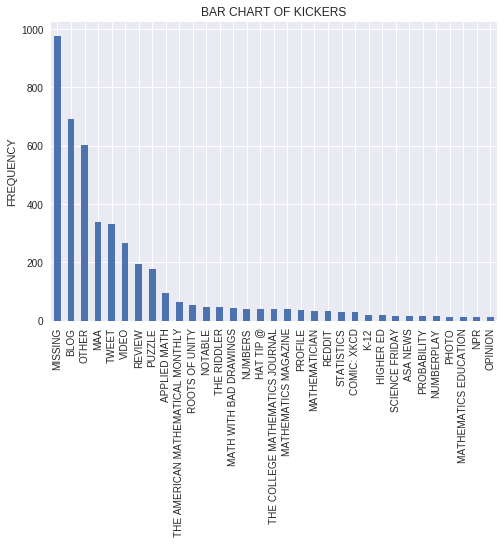

MISSING                              977
BLOG                                 693
OTHER                                604
MAA                                  337
TWEET                                332
VIDEO                                265
REVIEW                               193
PUZZLE                               177
APPLIED MATH                          94
THE AMERICAN MATHEMATICAL MONTHLY     63
ROOTS OF UNITY                        52
NOTABLE                               47
THE RIDDLER                           46
MATH WITH BAD DRAWINGS                43
NUMBERS                               41
HAT TIP @                             39
THE COLLEGE MATHEMATICS JOURNAL       38
MATHEMATICS MAGAZINE                  38
PROFILE                               37
MATHEMATICIAN                         33
REDDIT                                33
STATISTICS                            31
COMIC: XKCD                           28
K-12                                  18
HIGHER ED       

In [7]:
#frequency of various kickers
df.kicker.value_counts().plot(kind='bar')
plt.title('BAR CHART OF KICKERS')
plt.ylabel('FREQUENCY')
plt.show()
# for i in range(100,0,-1):
# #     print(i)
#     print(i,sum(df.kicker.value_counts()== i))
print(df.kicker.value_counts())
# df.kicker.value_counts()

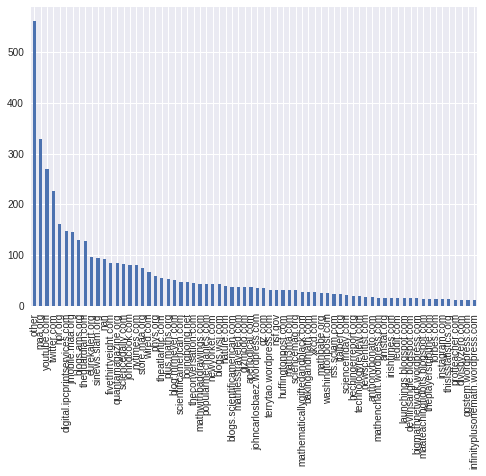

other                                560
maa.org                              329
youtube.com                          270
twitter.com                          227
npr.org                              161
digital.ipcprintservices.com         147
jmobile.maa.org                      145
blogs.ams.org                        130
theguardian.com                      128
eurekalert.org                        97
sinews.siam.org                       95
nan                                   93
fivethirtyeight.com                   84
quantamagazine.org                    84
sciencedaily.com                      83
johndcook.com                         81
nytimes.com                           80
store.maa.org                         75
wired.com                             66
phys.org                              60
theatlantic.com                       55
plus.maths.org                        53
blog.mrmeyer.com                      51
scientificamerican.com                48
boingboing.net  

In [8]:
#frequency of various domains
#note that 'nan' has a count of 93 (we can still leave this as its own category)
df.Domain.value_counts().plot(kind='bar')
plt.show()
print(df.Domain.value_counts())

### Feature Engineering
##### Target Variable

Min: -2.0 Max: 92.0
Reaction <= 0: 2553 Reaction > 0: 1833


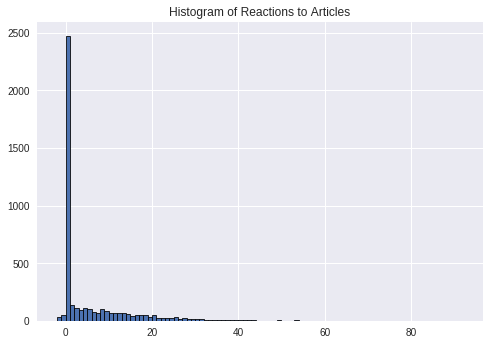

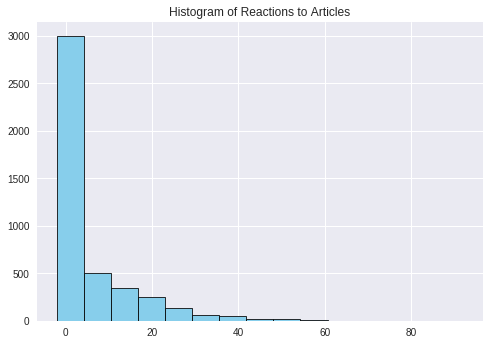

Total Articles: 4386
Popular Articles: 1833 ; 41.7920656635
Non-popular Articles: 2553 ; 58.2079343365


In [9]:
#MAKE A TARGET VARIABLE (popularity)
#how many times was each article reacted to? (save,open,share,email = +1; delete = -1)
df['reaction'] = pd.to_numeric(df.timesShared+df.timesOpened+df.timesSaved+df.timesEmailed-df.timesDeleted)
#popularity is an indicator variable for whether an article was reacted to (positively) or not
df['popularity'] = np.where(df.reaction > 0,1,0)

df.popularity.value_counts()
df.reaction.describe()

#histogram of reaction and counts of each type
print('Min:',min(df.reaction),'Max:',max(df.reaction))
print('Reaction <= 0:',sum(df.reaction <=0),'Reaction > 0:',sum(df.reaction>0))

plt.hist(df.reaction,bins=94,edgecolor='black',linewidth=.8)
plt.title('Histogram of Reactions to Articles')
plt.show()
plt.hist(df.reaction,bins=15,color='skyblue',edgecolor='black',linewidth=.8)
plt.title('Histogram of Reactions to Articles')
plt.show()

#balance check for popular and not popular
pop = sum(df.popularity != 0)
non_pop = sum(df.popularity == 0)
print('Total Articles:', len(df.popularity))
print('Popular Articles:', pop,';',pop * 100 / len(df.popularity))
print('Non-popular Articles:', non_pop,';',non_pop * 100 / len(df.popularity))

In [12]:
## INCOMPLETE SECTION ##

#OTHER POSSIBLE TARGET VARIABLES

#is it from reputable domain ie (maa.org)

def isReputable(df,dom_list):
    """
    takes a list of reputable domains and marks each article as reputable (1) if its from that domain
    otherwise it is marked as non-reputable (0)
    """
    
    df['isReputable'] = np.zeros(df.shape[0])
    for i in range(0,df.shape[0]):
        if df.Domain[i] in dom_list:
            print(i)
#             df.isReputable[i] = 1
            
    return df

dom_list = ['maa.org','jmobile.maa.org','blogs.ams.org','npr.org','theguardian.com',
            'digital.ipcprintservices.com']
isReputable(df,dom_list)
print(df.isReputable)
print(sum(df.isReputable)/df.shape[0])


# df['isReputable'] = np.where(df.Domain.str.contains('maa.org'),1,0)
# reputs = sum(df.isReputable)
# print(reputs,df.shape,reputs/df.shape[0])

/home/matt494/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


0       1.0
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
6       0.0
7       1.0
8       0.0
9       0.0
10      1.0
11      0.0
12      1.0
13      1.0
14      0.0
15      1.0
16      0.0
17      0.0
18      1.0
19      0.0
20      0.0
21      0.0
22      0.0
23      0.0
24      0.0
25      0.0
26      0.0
27      1.0
28      1.0
29      0.0
       ... 
4356    0.0
4357    0.0
4358    1.0
4359    0.0
4360    0.0
4361    0.0
4362    0.0
4363    0.0
4364    0.0
4365    0.0
4366    0.0
4367    0.0
4368    0.0
4369    1.0
4370    0.0
4371    0.0
4372    0.0
4373    0.0
4374    1.0
4375    0.0
4376    0.0
4377    0.0
4378    0.0
4379    0.0
4380    0.0
4381    0.0
4382    0.0
4383    0.0
4384    0.0
4385    1.0
Name: isReputable, Length: 4386, dtype: float64
0.237118103055


In [ ]:
df.Domain [0] in dom_list

In [ ]:
# df.columns
# df.timesDeleted.value_counts()
# df.timesEmailed.value_counts()
# df.timesSaved.value_counts()
# df.timesShared.value_counts()
df['isReputable'] = np.zeros(df.shape[0])
df.head()

In [ ]:
print('Quality:',sum(df.popularity))
print('Not:',sum(df.popularity == 0))
# df.head()

## Looking at the Text

Now we will use a CountVectorizer to split up each message into its list of words.

In [ ]:
#there are 55 observations with no text

#we'll drop those for the time being
print(df.shape)
df['Text'] = np.array(df.Text,dtype='str')
print(sum(df.Text == 'None'))
df = df[df.Text != 'None']
print(sum(df.Text == 'None'))
print(df.shape)
# df.head()

Sklearn has several built in ways to vectorize the text. I have been running into problems though when I try to merge the vectorized text with the other features (such as web domain)

In [ ]:
#vectorizing the text

vectorizer = CountVectorizer()
counts = vectorizer.fit_transform(df.Text.values)
# df['cnt_vec'] = counts #gives warning message

# vectorizer = CountVectorizer()
# counts = vectorizer.fit_transform(data['message'].values)

# classifier = MultinomialNB()
# targets = data['class'].values
# classifier.fit(counts, targets)

In [ ]:
print('Quality:',sum(df.popularity),';',sum(df.popularity)*100/len(df.popularity))
print('Not:',sum(df.popularity==0),';',sum(df.popularity==0)*100/len(df.popularity))

## Fitting the Model

In [ ]:
#split up train/test data
X_train, X_test, y_train, y_test = train_test_split(counts, df.popularity, test_size=0.25, random_state=10)

##### SVM

In [ ]:
def train_svm(X, y):
    svm = SVC(C=1000000, kernel='rbf')
    svm.fit(X,y)
    return svm 

In [ ]:
#using just the text to predict popularity
train_start = time.time()
svm = train_svm(X_train, y_train)
train_end = time.time()
print('Training time:', train_end-train_start)
 

accuracy = svm.score(X_test, y_test)
print('Accuracy:',accuracy)


In [ ]:
#add a confusion matrix

#confusion_matrix(y_true,y_pred)
predictions = svm.predict(X_test)
# print(predictions)
confusion_matrix(y_test,predictions)

##### Naive Bayes

In [ ]:
def train_NB(X, y):
    NB = MultinomialNB()
    NB.fit(X,y)
    return NB 

In [ ]:
#using just the text
train_start = time.time()
NB = train_NB(X_train, y_train)
train_end = time.time()
print('Training complete', train_end-train_start)
 

accuracy = NB.score(X_test, y_test)
print('Accuracy:',accuracy)

In [ ]:
#add a confusion matrix

#confusion_matrix(y_true,y_pred)
predictions_NB = NB.predict(X_test)
# print(predictions)
confusion_matrix(y_test,predictions_NB)

## SCRATCH CODE

In [ ]:
# SCRATCH CODE FOR MODIFYING KICKER FEATURE
# print('BLOG' in temp.kicker[0],temp.kicker[0] in 'BLOG',temp.kicker[0])
# np.where('BLOG' in temp.kicker,'BLOG',temp.kicker)
blog=sum(temp.kicker.str.contains('BLOG'))
mag=sum(temp.kicker.str.contains('MAGAZINE'))
puzz=sum(temp.kicker.str.contains('PUZZLE'))
ams=sum(temp.kicker.str.contains('AMSTAT'))
vid=sum(temp.kicker.str.contains('VIDEO'))
rev = sum(temp.kicker.str.contains('REVIEW'))
jour = sum(temp.kicker.str.contains('JOURNAL'))
red = sum(temp.kicker.str.contains('REDDIT'))
ht = sum(temp.kicker.str.contains('HAT TIP @'))
stat = sum(temp.kicker.str.contains('STATISTICS'))
print(blog,mag,puzz,ams,vid,rev,jour,red,ht,stat)
# c=0
# for i in range(0,len(df.kicker)):
#     if 'STAT' in df.kicker[i]:
#         c += 1
#         print(df.kicker[i])
# print(c)
# print('STAT' in df.kicker)

In [ ]:
print(counts)

In [ ]:
type(counts)